## Matrix multiplication from foundations

[Jump_to lesson 8 video](https://course.fast.ai/videos/?lesson=8&t=1850)

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

## Check imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# export
from exp.nb_00 import *
import operator


def test(a, b, cmp, cname=None):
    """Test a and b using comparison operator `cmp`.`"""
    if cname is None:
        cname = cmp.__name__
    assert cmp(a, b), f"{cname}:\n{a}\n{b}"


def test_eq(a, b):
    """Test if a == b."""
    test(a, b, operator.eq, "==")

<IPython.core.display.Javascript object>

In [4]:
test_eq(TEST, "test")

<IPython.core.display.Javascript object>

In [5]:
test_eq(TEST, "test1")

AssertionError: ==:
test
test1

<IPython.core.display.Javascript object>

## Get data

In [6]:
# export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"

<IPython.core.display.Javascript object>

In [7]:
mpl.rcParams["image.cmap"] = "gray"

<IPython.core.display.Javascript object>

In [8]:
path = datasets.download_data(MNIST_URL, ext=".gz")
path

PosixPath('/Users/imad/.fastai/data/mnist.pkl.gz')

<IPython.core.display.Javascript object>

In [9]:
%ls {path.parent}

mnist.pkl.gz


<IPython.core.display.Javascript object>

In [10]:
with gzip.open(path, "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

<IPython.core.display.Javascript object>

Since Numpy array is not allowed, we need to convert them to PyTorch tensors.

In [11]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

<IPython.core.display.Javascript object>

Making sure the shapes are correct

In [12]:
assert n == y_train.shape[0] == 50_000
test_eq(c, 28 * 28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

<IPython.core.display.Javascript object>

In [13]:
img = x_train[0]
img.type()

'torch.FloatTensor'

<IPython.core.display.Javascript object>

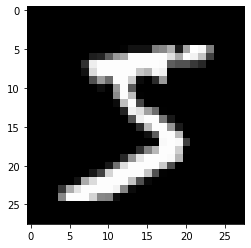

<IPython.core.display.Javascript object>

In [14]:
plt.imshow(img.view((28, 28)))

## Initial python model

Initialize weights to random numbers from normal distribution to avoid symmetric. It is fine to initialize biases to zeros.

In [15]:
# Linear model
weights = torch.randn(784, 10)
bias = torch.zeros(10)
weights.shape, bias.shape

(torch.Size([784, 10]), torch.Size([10]))

<IPython.core.display.Javascript object>

#### Matrix multiplication

In [16]:
def matmul(a, b):
    ar, ac = a.shape  # n_rows * n_cols
    br, bc = b.shape
    assert ac == br  # Condition for matrix multiplication
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):  # or br
                c[i, j] += a[i, k] * b[k, j]
    return c

<IPython.core.display.Javascript object>

In [17]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

<IPython.core.display.Javascript object>

In [18]:
%time t1=matmul(m1, m2)

CPU times: user 950 ms, sys: 3.98 ms, total: 954 ms
Wall time: 956 ms


<IPython.core.display.Javascript object>

In [19]:
t1.shape

torch.Size([5, 10])

<IPython.core.display.Javascript object>

This is kinda slow - what if we could speed it up by 50,000 times? Let's try!

In [20]:
len(x_train)

50000

<IPython.core.display.Javascript object>

We can utilize Aten library that PyTorch was written in to make it faster and remove Python from the loop.

#### Elementwise ops

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [21]:
a = tensor([10.0, 6, -4])
b = tensor([2.0, 8, 7])
a, b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

<IPython.core.display.Javascript object>

In [22]:
a + b

tensor([12., 14.,  3.])

<IPython.core.display.Javascript object>

In [23]:
(a < b).float().mean()

tensor(0.6667)

<IPython.core.display.Javascript object>

In [24]:
m = tensor([[1.0, 2, 3], [4, 5, 6], [7, 8, 9]])
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

<IPython.core.display.Javascript object>

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste.

In [25]:
(m * m).sum().sqrt()

tensor(16.8819)

<IPython.core.display.Javascript object>

#### Elementwise matmul

In [26]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i, j] = (a[i, :] * b[:, j]).sum()
    return c

<IPython.core.display.Javascript object>

In [27]:
%timeit -n 10 _=matmul(m1, m2)

1.24 ms ± 85.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>

In [28]:
943 / 1.37

688.3211678832116

<IPython.core.display.Javascript object>

In [29]:
# export
def near(a, b):
    return torch.allclose(a, b, rtol=1e-3, atol=1e-5)


def test_near(a, b):
    test(a, b, near)

<IPython.core.display.Javascript object>

In [30]:
test_near(t1, matmul(m1, m2))

<IPython.core.display.Javascript object>

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

#### Broadcasting with a scalar

In [31]:
a

tensor([10.,  6., -4.])

<IPython.core.display.Javascript object>

In [32]:
a > 0

tensor([ True,  True, False])

<IPython.core.display.Javascript object>

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [33]:
a + 1

tensor([11.,  7., -3.])

<IPython.core.display.Javascript object>

In [34]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

<IPython.core.display.Javascript object>

In [35]:
2 * m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

<IPython.core.display.Javascript object>

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [36]:
c = tensor([10.0, 20, 30])
c

tensor([10., 20., 30.])

<IPython.core.display.Javascript object>

In [37]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

<IPython.core.display.Javascript object>

In [38]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

<IPython.core.display.Javascript object>

In [39]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

<IPython.core.display.Javascript object>

In [40]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

<IPython.core.display.Javascript object>

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [41]:
t = c.expand_as(m)

<IPython.core.display.Javascript object>

In [42]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

<IPython.core.display.Javascript object>

In [43]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

<IPython.core.display.Javascript object>

Even though now t has shape 3 x 3, it still has the same representation in memory which is only rank 1 tensor. PyTorch is able to do that using stride. 

In [44]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

<IPython.core.display.Javascript object>

In [45]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

<IPython.core.display.Javascript object>

The above stride means that if you are moving across rows, the stride is zero (don't move), and if we are moving across columns the stride is 1 (move one step). The stride determines how to move within the storage of a tensor.

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [46]:
c.unsqueeze(0)

tensor([[10., 20., 30.]])

<IPython.core.display.Javascript object>

In [47]:
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

<IPython.core.display.Javascript object>

In [48]:
c.unsqueeze(-1)

tensor([[10.],
        [20.],
        [30.]])

<IPython.core.display.Javascript object>

In [49]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

<IPython.core.display.Javascript object>

In [50]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

<IPython.core.display.Javascript object>

We can use `None` to add a dimension to the tensor.

In [51]:
c.shape, c[None].shape, c[:, None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

<IPython.core.display.Javascript object>

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [52]:
c[None].shape, c[..., None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

<IPython.core.display.Javascript object>

In [53]:
c[:, None]

tensor([[10.],
        [20.],
        [30.]])

<IPython.core.display.Javascript object>

In [54]:
c[:, None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

<IPython.core.display.Javascript object>

In [55]:
c[:, None].expand_as(m).stride()

(1, 0)

<IPython.core.display.Javascript object>

In [56]:
c[:, None].expand_as(m).storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

<IPython.core.display.Javascript object>

In [57]:
m + c[:, None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

<IPython.core.display.Javascript object>

#### Matmul with broadcasting

In [58]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac == br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        #       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    return c

<IPython.core.display.Javascript object>

In [59]:
%timeit -n 10 _=matmul(m1, m2)

264 µs ± 21.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>

In [60]:
885000 / 277

3194.945848375451

<IPython.core.display.Javascript object>

In [61]:
test_near(t1, matmul(m1, m2))

<IPython.core.display.Javascript object>

#### Broadcasting Rules

In [62]:
c[None, :]

tensor([[10., 20., 30.]])

<IPython.core.display.Javascript object>

In [63]:
c[None, :].shape

torch.Size([1, 3])

<IPython.core.display.Javascript object>

In [64]:
c[:, None]

tensor([[10.],
        [20.],
        [30.]])

<IPython.core.display.Javascript object>

In [65]:
c[:, None].shape

torch.Size([3, 1])

<IPython.core.display.Javascript object>

When broadcasted, `c[None, :]` is broadcasted to have the same number of rows as `c[:, None]` and `c[:, None]` is broadcasted to have the same number of columns as `c[None, :]`.

In [66]:
c[None, :] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

<IPython.core.display.Javascript object>

In [67]:
c[None] > c[:, None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

<IPython.core.display.Javascript object>

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

So `torch.einsum('ik,kj->ij', a, b)` will give us a matrix of shape i x j where each entry of that matrix is a dot product with one row of matrix a and one column of matrix b. Since `k` is repeated the output will be summed.

In [68]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a, b):
    return torch.einsum("ik,kj->ij", a, b)

<IPython.core.display.Javascript object>

In [69]:
%timeit -n 10 _=matmul(m1, m2)

68.4 µs ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>

In [70]:
885000 / 55

16090.90909090909

<IPython.core.display.Javascript object>

In [71]:
test_near(t1, matmul(m1, m2))

<IPython.core.display.Javascript object>

It is now faster than the broadcasted version.

### pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

In [72]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 5.17 times longer than the fastest. This could mean that an intermediate result is being cached.
14.6 µs ± 9.69 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>

In [73]:
# time comparison vs pure python:
885000 / 18

49166.666666666664

<IPython.core.display.Javascript object>

The reason why `torch.matmul` is faster is that it breaks the matrices into smaller submatrices to keep them in cache and not keep fetching them from main memory. It is around 15 times faster than our broadcasted version because our implementation goes through rows and may fetch the same block of data multiple times instead of keeping it in cache.

In [74]:
# @ is the same as torch.matmul
t2 = m1 @ m2

<IPython.core.display.Javascript object>

In [75]:
test_near(t1, t2)

<IPython.core.display.Javascript object>

In [76]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

<IPython.core.display.Javascript object>

## Export

In [77]:
!python3 ../src/notebook2script.py 01_Matrix-Multiplication.ipynb

Converted 01_Matrix-Multiplication.ipynb to exp/nb_01.py


<IPython.core.display.Javascript object>